In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import cartopy.crs as ccrs
import os
import intake
import xesmf as xe
from datetime import datetime,timedelta
from matplotlib import rcParams
import matplotlib.patches as mpatches
import matplotlib as mpl
from analysisFuncs import (applyFunc,plot_map,getRegion,regions,
ens_list,templates,gcm_yr_list,var_name,loca_ens,getStats,gcm_dict)
import dask
dask.config.set({"array.slicing.split_large_chunks": True})
import geopandas

mask = xr.open_dataset('conus_gmet_mask2.nc')['mask'].values

def calculate_midpoints(arr,axis='lat'):
    
    midpoints = (arr[:-1] + arr[1:]) / 2
    return np.concatenate(([arr[0] - (arr[1] - arr[0]) / 2], midpoints, [arr[-1] + (arr[-1] - arr[-2]) / 2]))

def prepare_ds(ds):

    lat_midpoints = calculate_midpoints(ds['lat'].values,axis='lat')
    lon_midpoints = calculate_midpoints(ds['lon'].values,axis='lon')

    ds_out = ds.to_dataset().assign(lat_b=xr.DataArray(lat_midpoints, dims=['y_b']))
    ds_out = ds_out.assign(lon_b=xr.DataArray(lon_midpoints, dims=['x_b']))

    return(ds_out)

## To plot t_mean signal

Retrieving GARD-LENS stats.
Retrieving GCM stats.


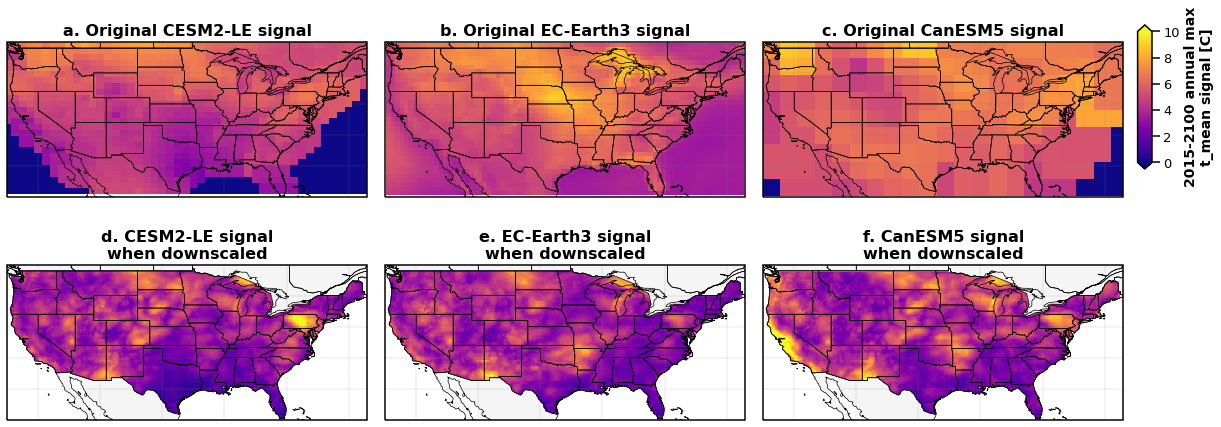

In [12]:


var='t_mean'

if var=='pcp': units='mm/d'
else: units = 'C'

reg = 'CONUS'
r = regions[reg]
runtag = ''
func = 'max'
period = ('2015','2100')

res = {}


print('Retrieving GARD-LENS stats.')

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_CONUS.nc'%var)[func]

for gcm in ('cesmlens2','ecearth3','canesm5'):
    ens_mean = ds.sel(n_ens=ds.gcm==gcm).sel(year=slice(period[0],period[1])).median('n_ens',skipna=True)
    res['GARD%s'%gcm] = applyFunc(ens_mean,'trend')


print('Retrieving GCM stats.')

for gcm in ('cesmlens2','ecearth3','canesm5'):
    ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/%s_%s_stats_CONUS.nc'%(gcm,var))[func]
    ens_mean = getRegion(ds,r,time=(period[0],period[1]),time_var='year').median('n_ens',skipna=True)
    res[gcm] = applyFunc(ens_mean,'trend')
    
    regridder = xe.Regridder(prepare_ds(res[gcm]),
                             prepare_ds(res['GARD%s'%gcm]), 'conservative')
    res['%s_hr'%gcm] = regridder(prepare_ds(res[gcm]))['polyfit_coefficients']


proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(20,8))

xlim = (-125.,-67.)
ylim = (25.,50.)

l = ('a.','b.','c.','d.','e.','f.')
if var=='pcp':
    cmap='seismic'; vmin=-100.; vmax=100.
else:
    cmap='plasma'; vmin=0.; vmax=10.

i=1
for gcm in ('cesmlens2','ecearth3','canesm5'):
    ax1 = fig.add_subplot(2,3,i,projection=proj)
    plot_map(res[gcm]*85,cmap='plasma',ax=ax1,vmin=vmin,vmax=vmax,xlim=xlim,ylim=ylim,
             bottom=False,left=False,colorbar=False,shrink=0.9)
    ax1.set_title('%s Original %s signal'%(l[i-1],gcm_dict[gcm]))

    ax1 = fig.add_subplot(2,3,i+3,projection=proj)
    plot_map(85*res['GARD%s'%gcm].drop('degree').where(mask),cmap='plasma',xlim=xlim,ylim=ylim,shrink=0.1,
             ax=ax1,bottom=False,left=False,vmin=vmin,vmax=vmax,colorbar=False)
    ax1.set_title('%s %s signal\nwhen downscaled'%(l[i+2],gcm_dict[gcm]))
    i+=1


ax2 = fig.add_axes([0.91, 0.61, 0.01, 0.25])
cb = mpl.colorbar.ColorbarBase(ax2, orientation='vertical', 
                               cmap=cmap,
                               norm=mpl.colors.Normalize(vmin,vmax),  # vmax and vmin
                               extend='both',
                               label='2015-2100 annual %s\n%s signal [%s]'%(func,var,units))
cb.ax.tick_params(labelsize=13)

plt.subplots_adjust(wspace=0.05,hspace=.05)
# fig.savefig('figures/CLIVAR_SignalChangeMap_%s_%s.jpg'%(func,var),dpi=1200,bbox_inches='tight')
plt.show()

## To plot pcp si

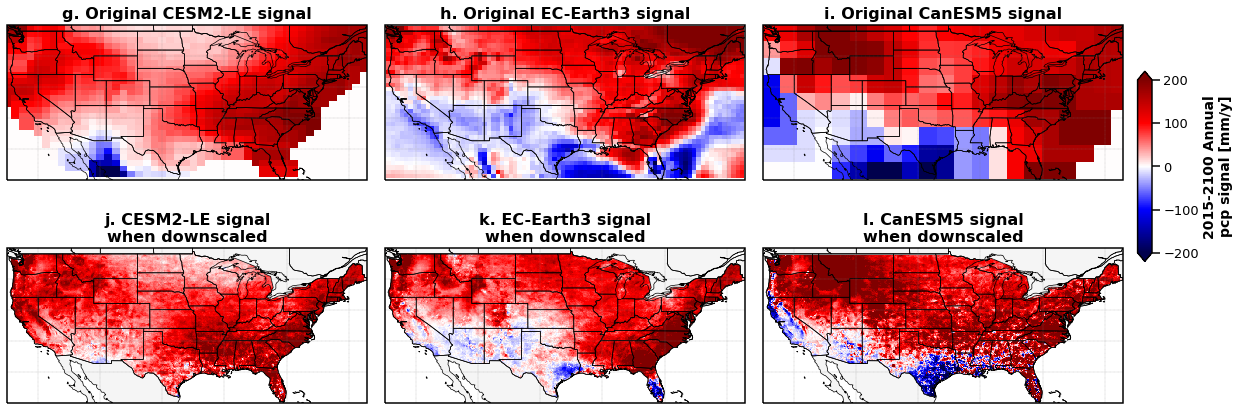

In [32]:


var='pcp'

if var=='pcp': units='mm/d'
else: units = 'C'

reg = 'CONUS'
r = regions[reg]
runtag = ''
func = 'sum'
period = ('2015','2100')

res = {}


print('Retrieving GARD-LENS stats.')

ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/GARDLENS_%s_stats_CONUS.nc'%var)[func]

for gcm in ('cesmlens2','ecearth3','canesm5'):
    ens_mean = getRegion(ds.sel(n_ens=ds.gcm==gcm),r,time=(period[0],period[1]),time_var='year').median('n_ens',skipna=True)
    res['GARD%s'%gcm] = applyFunc(ens_mean,'trend')


print('Retrieving GCM stats.')

for gcm in ('cesmlens2','ecearth3','canesm5'):
    ds = xr.open_dataset('/glade/campaign/ral/hap/hartke/stat_files/%s_%s_stats_CONUS.nc'%(gcm,var))[func]
    ens_mean = getRegion(ds,r,time=(period[0],period[1]),time_var='year').median('n_ens',skipna=True)
    res[gcm] = applyFunc(ens_mean,'trend')
    
    regridder = xe.Regridder(prepare_ds(res[gcm]),
                             prepare_ds(res['GARD%s'%gcm]), 'conservative')
    res['%s_hr'%gcm] = regridder(prepare_ds(res[gcm]))['polyfit_coefficients']



proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(20,8))

xlim = (-125.,-67.)
ylim = (25.,50.)

l = ('g.','h.','i.','j.','k.','l.')
i=1
for gcm in ('cesmlens2','ecearth3','canesm5'):
    ax1 = fig.add_subplot(2,3,i,projection=proj)
    plot_map(res[gcm]*85,cmap='seismic',ax=ax1,vmin=-200.,vmax=200.,xlim=xlim,ylim=ylim,
             bottom=False,left=False,colorbar=False)
    ax1.set_title('%s Original %s signal'%(l[i-1],gcm_dict[gcm]))

    ax1 = fig.add_subplot(2,3,i+3,projection=proj)
    #change = 100*(res['GARD%s'%gcm]-res['%s_hr'%gcm])/res['%s_hr'%gcm]
    change = res['GARD%s'%gcm]
    plot_map(change.where(mask)*85,cmap='seismic',xlim=xlim,ylim=ylim,
             ax=ax1,bottom=False,left=False,vmin=-200.,vmax=200.,colorbar=False)
    ax1.set_title('%s %s signal\nwhen downscaled'%(l[i+2],gcm_dict[gcm]))
    i+=1

ax2 = fig.add_axes([.91, 0.42, 0.01, 0.33])
cb = mpl.colorbar.ColorbarBase(ax2, orientation='vertical', 
                               cmap='seismic',
                               norm=mpl.colors.Normalize(-200., 200.),  # vmax and vmin
                               extend='both',
                               label='2015-2100 Annual\npcp signal [mm/y]')
cb.ax.tick_params(labelsize=13)

plt.subplots_adjust(wspace=0.05,hspace=.05)
#fig.savefig('figures/CLIVAR_SignalChangeMap_%s_%s.jpg'%(func,var),dpi=1200,bbox_inches='tight')

plt.show()